## This Notebook is divided into three main sections:
#### Section A: Data Imputation Techniques 
#### Section B: GradientBoosting Implementation on the Titanic Dataset 
#### Section C: Testing a theory on increasing number of decision trees (n_estimators) for GradientBoosting 
</br>




--------------------------------------------------------------------------------------------------------
</br>

### Section A: Data Imputation Techniques</br>
The high level steps in this section will include the following:</br>






> 1.1 Importing the neccessary libraries</br>
> 1.2 Importing the dataset</br>
> 1.3 Analyzing the features</br>
> 1.4 Performing the imputation using two techniques</br>
>> Building the model for each of the imputation techniques</br>
>> Evaluating Classifier Accuracy for each of the imputation techniques</br>

#### 1.1 Importing the neccessary libraries

In [1]:
# importing the neccessary libraries

# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype,is_numeric_dtype


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# imputation
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier




#### 1.2 Importing the dataset

In [2]:
%pwd

'/Users/khajan/OneDrive - Northeastern University/Post Admittance/001 Fall 2020 Semester/INFO6105/001 Assignment 2'

In [3]:
data_path = 'path/to/file'

In [4]:
!ls

Assignment 2.docx                      assignment_2_impute_khajan.ipynb
Khajan_Assignment2.ipynb               assignment_2_impute_khajan_final.ipynb
Khajan_Joshi_Assignment2.docx          test.csv
Khajan_Joshi_Assignment2.ipynb         train.csv
Titanic_full.csv


In [5]:
my_df = pd.read_csv(f'{data_path}/Titanic_full.csv')

#### 1.3 Analyzing the features

In [6]:
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
# Using the info to see object types and null values in brief
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [8]:
# Let's see which all columns have no nulls. True: number of non-nulls, False: number of nulls

for column in my_df.columns:
    print(my_df[column].notnull().value_counts())
    print('\t')

True    1309
Name: PassengerId, dtype: int64
	
True    1309
Name: Survived, dtype: int64
	
True    1309
Name: Pclass, dtype: int64
	
True    1309
Name: Name, dtype: int64
	
True    1309
Name: Sex, dtype: int64
	
True     1046
False     263
Name: Age, dtype: int64
	
True    1309
Name: SibSp, dtype: int64
	
True    1309
Name: Parch, dtype: int64
	
True    1309
Name: Ticket, dtype: int64
	
True     1308
False       1
Name: Fare, dtype: int64
	
False    1014
True      295
Name: Cabin, dtype: int64
	
True     1307
False       2
Name: Embarked, dtype: int64
	


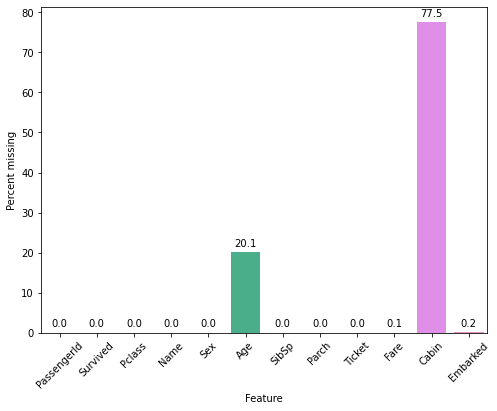

In [9]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = my_df.isnull().sum()/len(my_df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
bplot = sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

# annotating the % of nulls on the bar
# looping through each bar and using annotate function. In this function, we can format and place annotated text, like location of annotation, etc.
for p in bplot.patches:
    bplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [10]:
# First of all, I will completely discard the "Cabin" column as there are too many missing values. Also, it is alphanumeric, so we would only be guessing
# plus cabin number would probably not provide insight about survival. Pclass and Fare would in some way correlate to cabin, and those can 
# be used to provide insights about survival.

In [11]:
# Dropping the Cabin column
my_df_dropped = my_df.drop('Cabin',axis=1)
print(my_df_dropped.shape)
my_df_dropped.head(5)

(1309, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


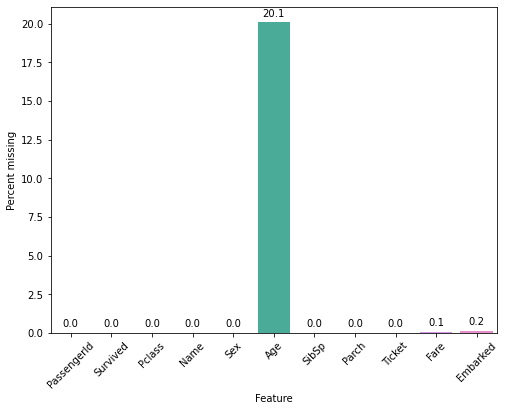

In [12]:
# let's see the missing values again

null_vals_dropped = my_df_dropped.isnull().sum()/len(my_df_dropped)*100
null_vals_dropped = pd.DataFrame(null_vals_dropped)
null_vals_dropped.reset_index(inplace = True)
null_vals_dropped.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
bplot_dropped = sns.barplot(x = "Feature",y ="Percent missing",data = null_vals_dropped)

# annotating the % of nulls on the bar
# looping through each bar and using annotate function. In this function, we can format and place annotated text, like location of annotation, etc.
for p in bplot_dropped.patches:
    bplot_dropped.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

#### 1.4 Performing the imputation

##### Here's the plan 

</br>

1. Replace null values with the mode</br>
2. Using k-NN to impute nulls</br>

--------------------------------------------------------------------------------------------------------

#### Imputation technique 1. Replace null values with the mode

In [13]:
# So we have three columns with nulls
# We will handle the missing values for categorical and continuous variables separately. "Embarked" is categorical and "Age" and "Fare" are continuous

In [14]:
# Let's start with the categorical type nulls
# Let's see what is the mode for Embarked
my_df_dropped['Embarked'].describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [15]:
# replacing missing values in "Embarked" with the mode
my_df_impute1_mid=my_df_dropped
my_df_impute1_mid['Embarked'].replace(to_replace=np.nan, value='S', inplace=True, limit=None, regex=False, method='pad')

In [16]:
my_df_impute1_mid['Embarked'].describe()

count     1309
unique       3
top          S
freq       916
Name: Embarked, dtype: object

In [17]:
# now numeric imputation

In [18]:
# This should be the replaced null calue for "Age"
my_df_impute1_mid['Age'].mode()

0    24.0
dtype: float64

In [19]:
# for "Fare"
my_df_impute1_mid['Fare'].mode()

0    8.05
dtype: float64

In [20]:
my_df_impute1_mid.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [21]:
my_df_impute1_mid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1309 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


In [22]:
# Using scikit learn's SimpleImputer, we will replace the nulls with the mode for the continuous variables
impute1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value='constant', verbose=0, copy=True, add_indicator=False)
impute1_fit = impute1.fit(my_df_impute1_mid)
impute1_transform = impute1.transform(my_df_impute1_mid)

#Since the transorm operation on the dataframe returns an array, we will convert if back to a Dataframe and then add the same column names again
# Also, the array will not retain the same dtypes. So we will input th same from previous dataframe and also change object to categorical at the same time
imputed1_df=pd.DataFrame(data=impute1_transform)
imputed1_df.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked']
imputed1_df = imputed1_df.astype({'PassengerId':'int64', 'Survived':'int64','Pclass':'int64', 'Name':'category', 'Sex':'category', 'Age':'float64', 'SibSp':'int64',
       'Parch':'int64', 'Ticket':'category', 'Fare':'float64', 'Embarked':'category'}) 
imputed1_df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,24.0,0,0,A.5. 3236,8.0500,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,1,3,"Ware, Mr. Frederick",male,24.0,0,0,359309,8.0500,S


In [23]:
imputed1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     1309 non-null   int64   
 2   Pclass       1309 non-null   int64   
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1309 non-null   float64 
 6   SibSp        1309 non-null   int64   
 7   Parch        1309 non-null   int64   
 8   Ticket       1309 non-null   category
 9   Fare         1309 non-null   float64 
 10  Embarked     1309 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 177.0 KB


In [24]:
imputed1_df['Age'].isnull().value_counts()

False    1309
Name: Age, dtype: int64

In [25]:
imputed1_df['Fare'].isnull().value_counts()

False    1309
Name: Fare, dtype: int64

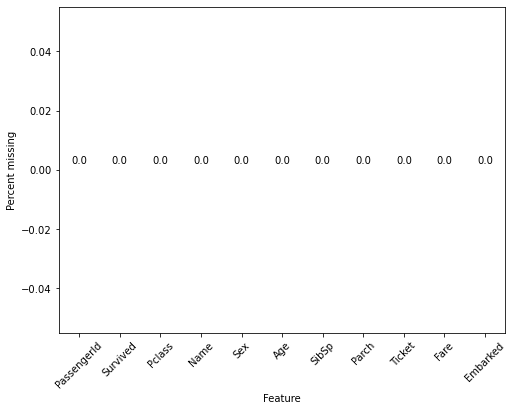

In [26]:
# let's see the missing values again

null_vals_dropped1 = imputed1_df.isnull().sum()/len(imputed1_df)*100
null_vals_dropped1 = pd.DataFrame(null_vals_dropped1)
null_vals_dropped1.reset_index(inplace = True)
null_vals_dropped1.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
bplot_dropped1 = sns.barplot(x = "Feature",y ="Percent missing",data = null_vals_dropped1)

# annotating the % of nulls on the bar
# looping through each bar and using annotate function. In this function, we can format and place annotated text, like location of annotation, etc.
for p in bplot_dropped1.patches:
    bplot_dropped1.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [27]:
imputed1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     1309 non-null   int64   
 2   Pclass       1309 non-null   int64   
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1309 non-null   float64 
 6   SibSp        1309 non-null   int64   
 7   Parch        1309 non-null   int64   
 8   Ticket       1309 non-null   category
 9   Fare         1309 non-null   float64 
 10  Embarked     1309 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 177.0 KB


In [28]:
imputed1_df



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,24.0,0,0,A.5. 3236,8.0500,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,1,3,"Ware, Mr. Frederick",male,24.0,0,0,359309,8.0500,S


In [29]:
'''I'm using the same functions defined in the provided code for converting the categorical features to numbers.
Since the nulls have already been handled, the null_table will be empty'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [30]:
my_df_impute1,my_table = mydf_preprocessor(imputed1_df,null_table = None)

In [31]:
my_df_impute1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,155,1,22.0,1,0,720,7.2500,2
1,2,1,1,286,0,38.0,1,0,816,71.2833,0
2,3,1,3,523,0,26.0,0,0,914,7.9250,2
3,4,1,1,422,0,35.0,1,0,65,53.1000,2
4,5,0,3,22,1,35.0,0,0,649,8.0500,2
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,1126,1,24.0,0,0,711,8.0500,2
1305,1306,1,1,891,0,39.0,0,0,834,108.9000,0
1306,1307,0,3,1046,1,38.5,0,0,872,7.2500,2
1307,1308,1,3,1227,1,24.0,0,0,579,8.0500,2


In [32]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = my_df_impute1["Survived"]
X = my_df_impute1.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1309, 10) (1309,)


In [33]:
# Doing a vertical split on the continuous and categorical features

X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1309, 8) (1309, 2)


In [34]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1309, 2)


,Age,Fare
0,-0.511722,-0.503176
1,0.710389,0.734809


In [35]:
''' Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1309, 10)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age,Fare
0,1,3,155,1,1,0,720,2,-0.511722,-0.503176
1,2,1,286,0,1,0,816,0,0.710389,0.734809


### Train-valid split

In [36]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid_x,mydf_test_x = mydf_splitter(X_full,1100)
mydf_train_valid_y,mydf_test_y = mydf_splitter(Y,1100)

print("Train-valid X: ",mydf_train_valid_x.shape,"\nTest X: ",mydf_test_x.shape)
print("\nTrain-valid Y: ",mydf_train_valid_y.shape,"\nTest Y: ",mydf_test_y.shape)

Train-valid X:  (1100, 10) 
Test X:  (209, 10)

Train-valid Y:  (1100,) 
Test Y:  (209,)


In [37]:
X_valid,X_train = mydf_splitter(mydf_train_valid_x,200)
Y_valid,Y_train = mydf_splitter(mydf_train_valid_y,200)

print("Train X: ",X_train.shape,"\nValid X: ",X_valid.shape,"\nTrain Y: ",Y_train.shape,"\nValid Y: ",Y_valid.shape)

Train X:  (900, 10) 
Valid X:  (200, 10) 
Train Y:  (900,) 
Valid Y:  (200,)


>> ### Building the model (train-valid)

In [38]:
# Building the model with train and valid set and k = 33 (as per hyperparameter tuning from previous trials)

my_knn_model = KNeighborsClassifier(n_neighbors = 33,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the test set
Y_pred_valid = my_knn_model.predict(X_valid)


>> ### Evaluating Classifier Accuracy

In [39]:
# accuracy score

accuracy_score(Y_valid,Y_pred_valid)

0.595

>>> #### *Confusion matrix, Recall, and Precision*

In [40]:
'''Make a confusion matrix for the K = 33 model based validation set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat_1 = confusion_matrix(Y_valid,Y_pred_valid)
c_mat_df_1 = pd.DataFrame(c_mat_1)
c_mat_df_1.head(2)

,0,1
0,99,32
1,49,20


Text(51.0, 0.5, 'Predicted')

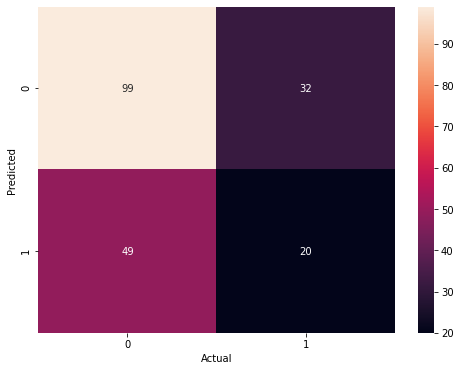

In [41]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_1,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

>>> #### *Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)*

    0   1
0  99  32
1  49  20
tp_1 =  99
tn_1 =  20
fp_1 =  32
fn_1 =  49

recall_1 =  0.668918918918919      precision_1 =  0.7557251908396947

f1 score_1 =  0.7096774193548389

scores_1 = 
               precision    recall  f1-score   support

           0       0.67      0.76      0.71       131
           1       0.38      0.29      0.33        69

    accuracy                           0.59       200
   macro avg       0.53      0.52      0.52       200
weighted avg       0.57      0.59      0.58       200



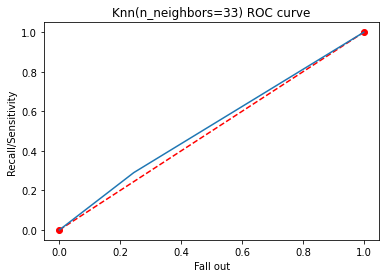

In [42]:
print(c_mat_df_1)
tp_knn_1 = c_mat_df_1.loc[0,0]
print('tp_1 = ',tp_knn_1)

tn_knn_1 = c_mat_df_1.loc[1,1]
print('tn_1 = ',tn_knn_1)

fp_knn_1 = c_mat_df_1.loc[0,1]
print('fp_1 = ',fp_knn_1)

fn_knn_1 = c_mat_df_1.loc[1,0]
print('fn_1 = ',fn_knn_1)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_knn_1 = tp_knn_1/(tp_knn_1+fn_knn_1)
precision_knn_1 = tp_knn_1/(tp_knn_1+fp_knn_1)
print('\nrecall_1 = ',recall_knn_1,'     precision_1 = ',precision_knn_1)

#F1 score = 2*(precision * recall)/precision + recall

f_score_knn_1 = (2*recall_knn_1*precision_knn_1)/(recall_knn_1+precision_knn_1)
print('\nf1 score_1 = ',f_score_knn_1)

# using the built in scikit-learn function to do this at one go!

scores_knn_1 = classification_report(Y_valid,Y_pred_valid)
print('\nscores_1 = \n',scores_knn_1)

rec_knn_1, fall_out_knn_1, thresholds_knn_1 = roc_curve(Y_valid,Y_pred_valid)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_knn_1,fall_out_knn_1, label='my_knn_df_1')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=33) ROC curve')
plt.show()

<br>

> ## Using the train_valid-test data

In [43]:
# Let's check the test data
mydf_test_x

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age,Fare
1100,1101,3,319,1,0,0,533,2,-0.282577,-0.490691
1101,1102,3,28,1,0,0,743,2,0.252097,-0.207858
1102,1103,3,383,1,0,0,877,2,-0.358959,-0.507043
1103,1104,2,314,1,0,0,847,2,-0.893632,0.777665
1104,1105,2,563,0,1,0,185,2,2.390793,-0.140674
...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,1126,1,0,0,711,2,-0.358959,-0.487709
1305,1306,1,891,0,0,0,834,0,0.786771,1.462069
1306,1307,3,1046,1,0,0,872,2,0.748580,-0.503176
1307,1308,3,1227,1,0,0,579,2,-0.358959,-0.487709


In [44]:
# Assigning Y_t to y test and X_t to x test dataframes


Y_t = mydf_test_y
X_t = mydf_test_x

print(X_t.shape,Y_t.shape)

(209, 10) (209,)


In [45]:
X_t

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age,Fare
1100,1101,3,319,1,0,0,533,2,-0.282577,-0.490691
1101,1102,3,28,1,0,0,743,2,0.252097,-0.207858
1102,1103,3,383,1,0,0,877,2,-0.358959,-0.507043
1103,1104,2,314,1,0,0,847,2,-0.893632,0.777665
1104,1105,2,563,0,1,0,185,2,2.390793,-0.140674
...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,1126,1,0,0,711,2,-0.358959,-0.487709
1305,1306,1,891,0,0,0,834,0,0.786771,1.462069
1306,1307,3,1046,1,0,0,872,2,0.748580,-0.503176
1307,1308,3,1227,1,0,0,579,2,-0.358959,-0.487709


In [46]:
Y_t

1100    1
1101    0
1102    1
1103    0
1104    0
       ..
1304    0
1305    1
1306    0
1307    1
1308    1
Name: Survived, Length: 209, dtype: int64

In [47]:
X_full

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age,Fare
0,1,3,155,1,1,0,720,2,-0.511722,-0.503176
1,2,1,286,0,1,0,816,0,0.710389,0.734809
2,3,3,523,0,0,0,914,2,-0.206195,-0.490126
3,4,1,422,0,1,0,65,2,0.481243,0.383263
4,5,3,22,1,0,0,649,2,0.481243,-0.487709
...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,1126,1,0,0,711,2,-0.358959,-0.487709
1305,1306,1,891,0,0,0,834,0,0.786771,1.462069
1306,1307,3,1046,1,0,0,872,2,0.748580,-0.503176
1307,1308,3,1227,1,0,0,579,2,-0.358959,-0.487709


>> ### Building the model

In [48]:
# Building the model with train and test set and k = 33

my_knn_model_test = KNeighborsClassifier(n_neighbors = 33,weights = 'uniform')
my_knn_model_test.fit(X_full,Y)

#Predict on the test set
Y_pred_test = my_knn_model.predict(X_t)

</br>

>> ### Evaluating Classifier Accuracy

In [49]:
# accuracy score

accuracy_score(Y_t,Y_pred_test)

0.5598086124401914

>>> #### *Confusion matrix, Recall, and Precision*

In [50]:
'''Make a confusion matrix for the K = 33 model based validation set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat_t = confusion_matrix(Y_t,Y_pred_test)
c_mat_df_t = pd.DataFrame(c_mat_t)
c_mat_df_t.head(2)

,0,1
0,117,1
1,91,0


Text(51.0, 0.5, 'Predicted')

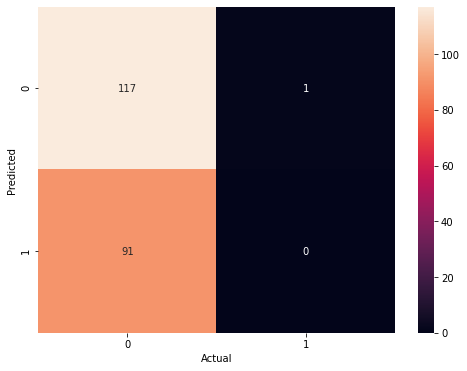

In [51]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_t,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

>>> #### *Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)*

     0  1
0  117  1
1   91  0
tp_t =  117
tn_t =  0
fp_t =  1
fn_t =  91

recall_t =  0.5625      precision_t =  0.9915254237288136

f1 score_t =  0.7177914110429447

scores_t = 
               precision    recall  f1-score   support

           0       0.56      0.99      0.72       118
           1       0.00      0.00      0.00        91

    accuracy                           0.56       209
   macro avg       0.28      0.50      0.36       209
weighted avg       0.32      0.56      0.41       209



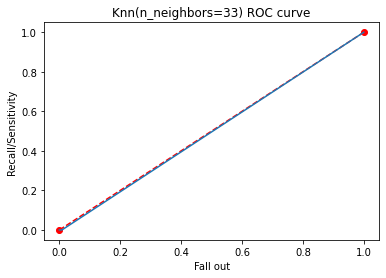

In [52]:
print(c_mat_df_t)
tp_knn_t = c_mat_df_t.loc[0,0]
print('tp_t = ',tp_knn_t)

tn_knn_t = c_mat_df_t.loc[1,1]
print('tn_t = ',tn_knn_t)

fp_knn_t = c_mat_df_t.loc[0,1]
print('fp_t = ',fp_knn_t)

fn_knn_t = c_mat_df_t.loc[1,0]
print('fn_t = ',fn_knn_t)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_knn_t = tp_knn_t/(tp_knn_t+fn_knn_t)
precision_knn_t = tp_knn_t/(tp_knn_t+fp_knn_t)
print('\nrecall_t = ',recall_knn_t,'     precision_t = ',precision_knn_t)

#F1 score = 2*(precision * recall)/precision + recall

f_score_knn_t = (2*recall_knn_t*precision_knn_t)/(recall_knn_t+precision_knn_t)
print('\nf1 score_t = ',f_score_knn_t)

# using the built in scikit-learn function to do this at one go!

scores_knn_t = classification_report(Y_t,Y_pred_test)
print('\nscores_t = \n',scores_knn_t)

rec_knn_t, fall_out_knn_t, thresholds_knn_t = roc_curve(Y_t,Y_pred_test)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_knn_t,fall_out_knn_t, label='my_knn_df_t')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=33) ROC curve')
plt.show()

--------------------------------------------------------------------------------------------------------
</br>

### Imputation technique 2.  Using k-NN to impute nulls

In [53]:
my_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1309 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


In [54]:
my_df_dropped

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S
1307,1308,1,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S


In [55]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers'''
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [56]:
my_df_impute2_mid = str_to_cat(my_df_dropped)

In [57]:

my_df_impute2_mid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     1309 non-null   int64   
 2   Pclass       1309 non-null   int64   
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   int64   
 7   Parch        1309 non-null   int64   
 8   Ticket       1309 non-null   category
 9   Fare         1308 non-null   float64 
 10  Embarked     1309 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 177.0 KB


In [58]:
# We have to first convert the strings to numbers before using the KNNImputer

my_df_impute2,my_table = mydf_preprocessor(my_df_impute2_mid,null_table = None)

In [59]:
my_df_impute2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,155,1,22.0,1,0,720,7.2500,2
1,2,1,1,286,0,38.0,1,0,816,71.2833,0
2,3,1,3,523,0,26.0,0,0,914,7.9250,2
3,4,1,1,422,0,35.0,1,0,65,53.1000,2
4,5,0,3,22,1,35.0,0,0,649,8.0500,2
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,1126,1,NaN,0,0,711,8.0500,2
1305,1306,1,1,891,0,39.0,0,0,834,108.9000,0
1306,1307,0,3,1046,1,38.5,0,0,872,7.2500,2
1307,1308,1,3,1227,1,NaN,0,0,579,8.0500,2


In [60]:
# Using the KNNImputer from scikit learn to impute the missing values with K = 5

imputer = KNNImputer(n_neighbors=5, weights="uniform")

my_df_impute2['Age'] = imputer.fit_transform(my_df_impute2[['Age']])
my_df_impute2['Fare'] = imputer.fit_transform(my_df_impute2[['Fare']])

print(my_df_impute2)

      PassengerId  Survived  Pclass  Name  Sex        Age  SibSp  Parch  \
0               1         0       3   155    1  22.000000      1      0   
1               2         1       1   286    0  38.000000      1      0   
2               3         1       3   523    0  26.000000      0      0   
3               4         1       1   422    0  35.000000      1      0   
4               5         0       3    22    1  35.000000      0      0   
...           ...       ...     ...   ...  ...        ...    ...    ...   
1304         1305         0       3  1126    1  29.881138      0      0   
1305         1306         1       1   891    0  39.000000      0      0   
1306         1307         0       3  1046    1  38.500000      0      0   
1307         1308         1       3  1227    1  29.881138      0      0   
1308         1309         1       3   953    1  29.881138      1      1   

      Ticket      Fare  Embarked  
0        720    7.2500         2  
1        816   71.2833       

In [61]:
# Imputation successfull

In [62]:
# So we'll start with the train_valid-test split 
# Then we need to preprocess the data

In [63]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y2 = my_df_impute2["Survived"]
X2 = my_df_impute2.drop(["Survived"],axis = 1)

print(X2.shape,Y2.shape)

(1309, 10) (1309,)


In [64]:
# Doing a vertical split on the continuous and categorical features

X_cat2 = X2[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked']]
X_con2 = X2.drop(X_cat2,axis = 1)
print(X_cat2.shape,X_con2.shape)

(1309, 8) (1309, 2)


In [65]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler2 = preprocessing.StandardScaler().fit(X_con2)
X_con_sc2 = pd.DataFrame(scaler.transform(X_con2))
X_con_sc2.columns = ["Age","Fare"]
print(X_con_sc2.shape)
X_con_sc2.head(2)

(1309, 2)


,Age,Fare
0,-0.511722,-0.503176
1,0.710389,0.734809


In [66]:
''' Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list2 = [X_cat2,X_con_sc2]
X_full2 = pd.concat(df_list2,axis = 1)
print(X_full2.shape)
X_full2.head(2)

(1309, 10)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age,Fare
0,1,3,155,1,1,0,720,2,-0.511722,-0.503176
1,2,1,286,0,1,0,816,0,0.710389,0.734809


### Train-valid split

In [67]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid_x2,mydf_test_x2 = mydf_splitter(X_full2,1100)
mydf_train_valid_y2,mydf_test_y2 = mydf_splitter(Y2,1100)

print("Train-valid X: ",mydf_train_valid_x2.shape,"\nTest X: ",mydf_test_x2.shape)
print("\nTrain-valid Y: ",mydf_train_valid_y2.shape,"\nTest Y: ",mydf_test_y2.shape)

Train-valid X:  (1100, 10) 
Test X:  (209, 10)

Train-valid Y:  (1100,) 
Test Y:  (209,)


In [68]:
X_valid2,X_train2 = mydf_splitter(mydf_train_valid_x2,200)
Y_valid2,Y_train2 = mydf_splitter(mydf_train_valid_y2,200)

print("Train X: ",X_train2.shape,"\nValid X: ",X_valid2.shape,"\nTrain Y: ",Y_train2.shape,"\nValid Y: ",Y_valid2.shape)

Train X:  (900, 10) 
Valid X:  (200, 10) 
Train Y:  (900,) 
Valid Y:  (200,)


>> ### Building the model (train-valid)

In [69]:
# Building the model with train and valid set and k = 33

my_knn_model2 = KNeighborsClassifier(n_neighbors = 33,weights = 'uniform')
my_knn_model2.fit(X_train2,Y_train2)

#Predict on the test set
Y_pred_valid2 = my_knn_model2.predict(X_valid2)


>> ### Evaluating Classifier Accuracy

In [70]:
# accuracy score

accuracy_score(Y_valid2,Y_pred_valid2)

0.595

>>> #### *Confusion matrix, Recall, and Precision*

In [71]:
'''Make a confusion matrix for the K = 5 model based validation set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat_2 = confusion_matrix(Y_valid2,Y_pred_valid2)
c_mat_df_2 = pd.DataFrame(c_mat_2)
c_mat_df_2.head(2)

,0,1
0,99,32
1,49,20


Text(51.0, 0.5, 'Predicted')

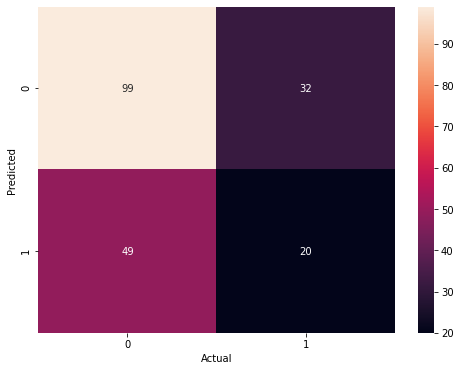

In [72]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_2,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

>>> #### *Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)*

    0   1
0  99  32
1  49  20
tp_2 =  99
tn_2 =  20
fp_2 =  32
fn_2 =  49

recall_2 =  0.668918918918919      precision_2 =  0.7557251908396947

f1 score_2 =  0.7096774193548389

scores_2 = 
               precision    recall  f1-score   support

           0       0.67      0.76      0.71       131
           1       0.38      0.29      0.33        69

    accuracy                           0.59       200
   macro avg       0.53      0.52      0.52       200
weighted avg       0.57      0.59      0.58       200



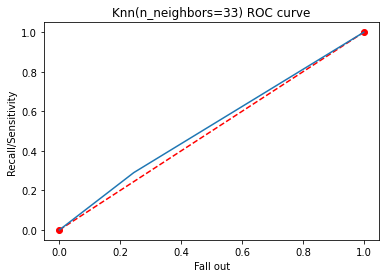

In [73]:
print(c_mat_df_2)
tp_knn_2 = c_mat_df_2.loc[0,0]
print('tp_2 = ',tp_knn_2)

tn_knn_2 = c_mat_df_2.loc[1,1]
print('tn_2 = ',tn_knn_2)

fp_knn_2 = c_mat_df_2.loc[0,1]
print('fp_2 = ',fp_knn_2)

fn_knn_2 = c_mat_df_2.loc[1,0]
print('fn_2 = ',fn_knn_2)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_knn_2 = tp_knn_2/(tp_knn_2+fn_knn_2)
precision_knn_2 = tp_knn_2/(tp_knn_2+fp_knn_2)
print('\nrecall_2 = ',recall_knn_2,'     precision_2 = ',precision_knn_2)

#F1 score = 2*(precision * recall)/precision + recall

f_score_knn_2 = (2*recall_knn_2*precision_knn_2)/(recall_knn_2+precision_knn_2)
print('\nf1 score_2 = ',f_score_knn_2)

# using the built in scikit-learn function to do this at one go!

scores_knn_2 = classification_report(Y_valid2,Y_pred_valid2)
print('\nscores_2 = \n',scores_knn_2)

rec_knn_2, fall_out_knn_2, thresholds_knn_2 = roc_curve(Y_valid2,Y_pred_valid2)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_knn_2,fall_out_knn_2, label='my_knn_df_2')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=33) ROC curve')
plt.show()


<br>

> ## Using the train_valid-test data

In [74]:
# Let's check the test data
mydf_test_x

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age,Fare
1100,1101,3,319,1,0,0,533,2,-0.282577,-0.490691
1101,1102,3,28,1,0,0,743,2,0.252097,-0.207858
1102,1103,3,383,1,0,0,877,2,-0.358959,-0.507043
1103,1104,2,314,1,0,0,847,2,-0.893632,0.777665
1104,1105,2,563,0,1,0,185,2,2.390793,-0.140674
...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,1126,1,0,0,711,2,-0.358959,-0.487709
1305,1306,1,891,0,0,0,834,0,0.786771,1.462069
1306,1307,3,1046,1,0,0,872,2,0.748580,-0.503176
1307,1308,3,1227,1,0,0,579,2,-0.358959,-0.487709


In [75]:
# Assigning Y_t to y test and X_t to x test dataframes


Y_t = mydf_test_y
X_t = mydf_test_x

print(X_t.shape,Y_t.shape)

(209, 10) (209,)


>> ### Building the model

In [76]:
# Building the model with train and test set and k = 33

my_knn_model_test2 = KNeighborsClassifier(n_neighbors = 33,weights = 'uniform')
my_knn_model_test2.fit(X_full2,Y)

#Predict on the test set
Y_pred_test2 = my_knn_model.predict(X_t)

</br>

>> ### Evaluating Classifier Accuracy

In [77]:
# accuracy score

accuracy_score(Y_t,Y_pred_test2)

0.5598086124401914

>>> #### *Confusion matrix, Recall, and Precision*

In [78]:
'''Make a confusion matrix for the K = 5 model based validation set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat_t = confusion_matrix(Y_t,Y_pred_test2)
c_mat_df_t = pd.DataFrame(c_mat_t)
c_mat_df_t.head(2)

,0,1
0,117,1
1,91,0


Text(51.0, 0.5, 'Predicted')

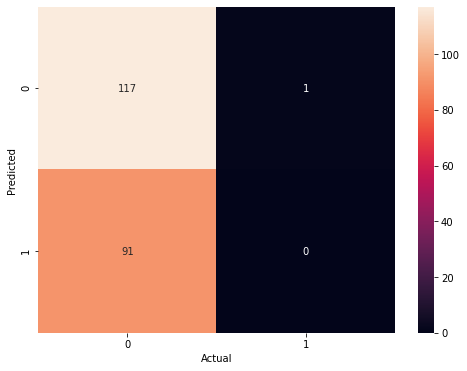

In [79]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_t,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

>>> #### *Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)*

     0  1
0  117  1
1   91  0
tp_t =  117
tn_t =  0
fp_t =  1
fn_t =  91

recall_t =  0.5625      precision_t =  0.9915254237288136

f1 score_t =  0.7177914110429447

scores_t = 
               precision    recall  f1-score   support

           0       0.56      0.99      0.72       118
           1       0.00      0.00      0.00        91

    accuracy                           0.56       209
   macro avg       0.28      0.50      0.36       209
weighted avg       0.32      0.56      0.41       209



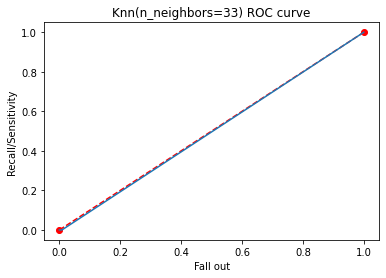

In [80]:
print(c_mat_df_t)
tp_knn_t = c_mat_df_t.loc[0,0]
print('tp_t = ',tp_knn_t)

tn_knn_t = c_mat_df_t.loc[1,1]
print('tn_t = ',tn_knn_t)

fp_knn_t = c_mat_df_t.loc[0,1]
print('fp_t = ',fp_knn_t)

fn_knn_t = c_mat_df_t.loc[1,0]
print('fn_t = ',fn_knn_t)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_knn_t = tp_knn_t/(tp_knn_t+fn_knn_t)
precision_knn_t = tp_knn_t/(tp_knn_t+fp_knn_t)
print('\nrecall_t = ',recall_knn_t,'     precision_t = ',precision_knn_t)

#F1 score = 2*(precision * recall)/precision + recall

f_score_knn_t = (2*recall_knn_t*precision_knn_t)/(recall_knn_t+precision_knn_t)
print('\nf1 score_t = ',f_score_knn_t)

# using the built in scikit-learn function to do this at one go!

scores_knn_t = classification_report(Y_t,Y_pred_test2)
print('\nscores_t = \n',scores_knn_t)

rec_knn_t, fall_out_knn_t, thresholds_knn_t = roc_curve(Y_t,Y_pred_test2)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_knn_t,fall_out_knn_t, label='my_knn_df_t')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=33) ROC curve')
plt.show()

In [81]:
# On the Titanic dataset, using both imputation techniques, there is no change in the model accuracy when using K-NN
# Now we will try GradientBoosting and see how the model performs on this dataset

--------------------------------------------------------------------------------------------------------
</br>

### Section B: GradientBoosting Implementation on the Titanic Dataset </br>
The high level steps in this section will include the following:</br>




</br>

#### •	Building a GradientBoosting model with default hyperparameter values

> - Using the train-valid data

>> Building the model</br>
>>  Evaluating Classifier Accuracy

> - Using the train_valid-test data

>> Building the model</br>
>> Evaluating Classifier Accuracy


--------------------------------------------------------------------------------------------------------
</br>

# •	Building a GradientBoosting model with default hyperparameter values


> ## Using the train-valid data


>> ### Building the model


In [82]:
# Using the default values of GradientBoostingClassifier from sklearn.ensemble

my_GB_model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [83]:
# Fitting the model on the training set and predicting on validation set

my_GB_model.fit(X_train,Y_train)

Y_pred_GB = my_GB_model.predict(X_valid)

>> ### Evaluating Classifier Accuracy

In [84]:
# accuracy score

accuracy_score(Y_valid,Y_pred_GB)

0.81

>>> #### *Confusion matrix, Recall, and Precision*

In [85]:
c_mat_GB = confusion_matrix(Y_valid,Y_pred_GB)
c_mat_df_GB = pd.DataFrame(c_mat_GB)
c_mat_df_GB.head(2)

,0,1
0,109,22
1,16,53


Text(51.0, 0.5, 'Predicted')

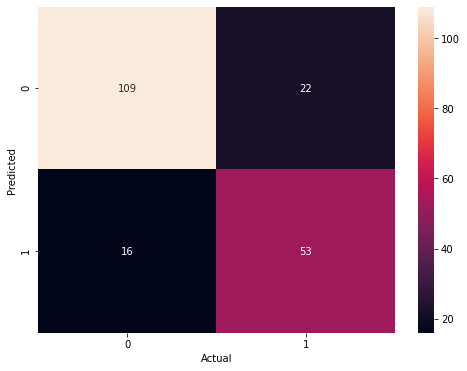

In [86]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_GB,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

>>> #### *Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)*

     0   1
0  109  22
1   16  53
tp_GB =  109
tn_GB =  53
fp_GB =  22
fn_GB =  16

recall_GB =  0.872      precision_GB =  0.8320610687022901

f1 score_GB =  0.8515625000000001

scores_GB = 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       131
           1       0.71      0.77      0.74        69

    accuracy                           0.81       200
   macro avg       0.79      0.80      0.79       200
weighted avg       0.81      0.81      0.81       200



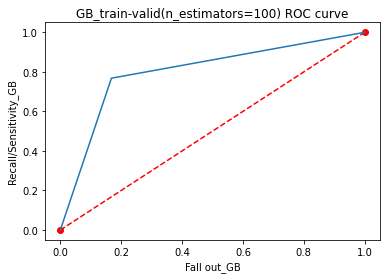

In [87]:
print(c_mat_df_GB)
tp_GB = c_mat_df_GB.loc[0,0]
print('tp_GB = ',tp_GB)

tn_GB = c_mat_df_GB.loc[1,1]
print('tn_GB = ',tn_GB)

fp_GB = c_mat_df_GB.loc[0,1]
print('fp_GB = ',fp_GB)

fn_GB = c_mat_df_GB.loc[1,0]
print('fn_GB = ',fn_GB)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_GB = tp_GB/(tp_GB+fn_GB)
precision_GB = tp_GB/(tp_GB+fp_GB)
print('\nrecall_GB = ',recall_GB,'     precision_GB = ',precision_GB)

#F1 score = 2*(precision * recall)/precision + recall

f_score_GB = (2*recall_GB*precision_GB)/(recall_GB+precision_GB)
print('\nf1 score_GB = ',f_score_GB)

# using the built in scikit-learn function to do this at one go!

scores_GB = classification_report(Y_valid,Y_pred_GB)
print('\nscores_GB = \n',scores_GB)

rec_GB, fall_out_GB, thresholds_GB = roc_curve(Y_valid,Y_pred_GB)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_GB,fall_out_GB, label='my_GB_df')
plt.xlabel('Fall out_GB')
plt.ylabel('Recall/Sensitivity_GB')
plt.title('GB_train-valid(n_estimators=100) ROC curve')
plt.show()


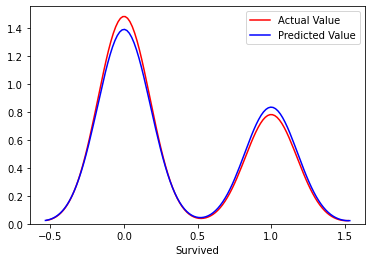

In [88]:
# generalization error

dist_code_t = sns.distplot(Y_valid,hist=False,color='r',label='Actual Value')
sns.distplot(Y_pred_GB,hist=False,color='b',label='Predicted Value',ax=dist_code_t)

In [89]:
# With the distribution plot, we can see a comparison between the actual and predicted Y values. 
# The curves are very similar for both. Which is a good sign that the model is performing well on the validation set at least
# Let's now see how it performs on the test set

> ## Using the train_valid-test data

>> ### Building the model

In [90]:
# Using the default values of GradientBoostingClassifier from sklearn.enemble

my_GB_model_t = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [91]:
# Fitting the model on the training-validation set and predicting on test set

my_GB_model_t.fit(X_full,Y)


Y_pred_GB_t = my_GB_model_t.predict(X_t)


>> ### Evaluating Classifier Accuracy

In [92]:
# accuracy score

accuracy_score(Y_t,Y_pred_GB_t)

0.8133971291866029

>>> #### *Confusion matrix, Recall, and Precision*

In [93]:
'''Make a confusion matrix for the n_estimators=100 model based validation set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat_GB_t = confusion_matrix(Y_t,Y_pred_GB_t)
c_mat_df_GB_t = pd.DataFrame(c_mat_GB_t)
c_mat_df_GB_t.head(2)

,0,1
0,107,11
1,28,63


Text(51.0, 0.5, 'Predicted')

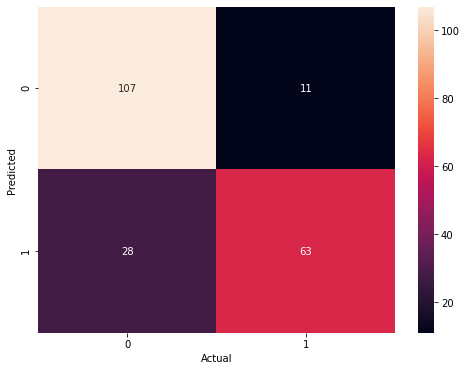

In [94]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_GB_t,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

>>> #### *Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)*

     0   1
0  107  11
1   28  63
tp_GB_t =  107
tn_GB_t =  63
fp_GB_t =  11
fn_GB_t =  28

recall_GB_t =  0.7925925925925926      precision_GB_t =  0.9067796610169492

f1 score_GB_t =  0.8458498023715416

scores_GB_t = 
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       118
           1       0.85      0.69      0.76        91

    accuracy                           0.81       209
   macro avg       0.82      0.80      0.80       209
weighted avg       0.82      0.81      0.81       209



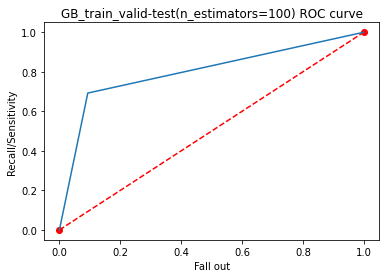

In [95]:
print(c_mat_df_GB_t)
tp_GB_t = c_mat_df_GB_t.loc[0,0]
print('tp_GB_t = ',tp_GB_t)

tn_GB_t = c_mat_df_GB_t.loc[1,1]
print('tn_GB_t = ',tn_GB_t)

fp_GB_t = c_mat_df_GB_t.loc[0,1]
print('fp_GB_t = ',fp_GB_t)

fn_GB_t = c_mat_df_GB_t.loc[1,0]
print('fn_GB_t = ',fn_GB_t)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_GB_t = tp_GB_t/(tp_GB_t+fn_GB_t)
precision_GB_t = tp_GB_t/(tp_GB_t+fp_GB_t)
print('\nrecall_GB_t = ',recall_GB_t,'     precision_GB_t = ',precision_GB_t)

#F1 score = 2*(precision * recall)/precision + recall

f_score_GB_t = (2*recall_GB_t*precision_GB_t)/(recall_GB_t+precision_GB_t)
print('\nf1 score_GB_t = ',f_score_GB_t)

# using the built in scikit-learn function to do this at one go!

scores_GB_t = classification_report(Y_t,Y_pred_GB_t)
print('\nscores_GB_t = \n',scores_GB_t)

rec_GB_t, fall_out_GB_t, thresholds_GB_t = roc_curve(Y_t,Y_pred_GB_t)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_GB_t,fall_out_GB_t, label='my_df_GB_t')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('GB_train_valid-test(n_estimators=100) ROC curve')
plt.show()


 **From the ROC curve for both train-valid and test predictions, we can see that the prediction is much better by using GradientBoosting</br>**
**Bias and variance is low as the model neither seems too under-fitted nor too over-fitted</br>**

--------------------------------------------------------------------------------------------------------
</br>

## Section C: Testing a theory on increasing number of decision trees (n_estimators) for GradientBoosting </br>

The need is to design and evaluate a computational experiment, to test the theory that increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability</br></br>
The high level steps in this section will include the following:</br>

Part 1 – Visualizing the accuracy for different values of n_estimators / number of decision trees</br>
Part 2 – Building a GradientBoosting model with the highest score n_estimators</br>






--------------------------------------------------------------------------------------------------------
</br>

## •	Part 1: Visualizing the accuracy for different values of n_estimators / number of decision trees


In [96]:
# Creating two lists, 
# one for the number of estimators 
# and one for acuracy and looping over n_estimators: 1 to 1000

num_estimators = list()
accuracy_list_GB = list()


for estimator in range(1,1001):
    my_GB_model_exp = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=estimator, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
    my_GB_model_exp.fit(X_train,Y_train)
    Y_pred_GB_exp = my_GB_model_exp.predict(X_valid)
    accuracy_GB_exp = accuracy_score(Y_valid,Y_pred_GB_exp)
    num_estimators.append(estimator)
    accuracy_list_GB.append(accuracy_GB_exp)

In [97]:
# Converting the estimator-accuracy lists to a dataframe. 
# Note: This operation takes about 10 mins to complete on my machine as 1100 GB models will be created (n_estimators: 1 to 1000)

eval_df_GB =  pd.DataFrame({"Num of estimators": num_estimators,"Valid accuracy Score": accuracy_list_GB})
eval_df_GB

,Num of estimators,Valid accuracy Score
0,1,0.655
1,2,0.655
2,3,0.765
3,4,0.790
4,5,0.790
...,...,...
995,996,0.740
996,997,0.740
997,998,0.710
998,999,0.745


/Users/khajan/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


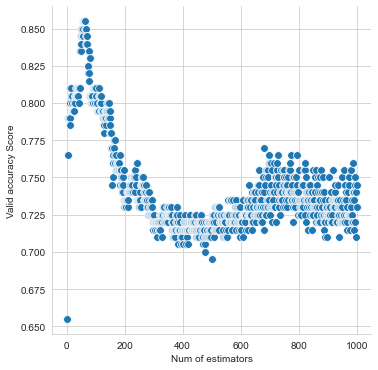

In [98]:
#Plot accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df_GB,x_vars = "Num of estimators",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0,size=5)

### As per the graph above, it does not seem like that the theory is true after some number of deciscion trees
We can see that there is a rise in accuracy for a ertain number of D-Trees (under 100) and then there is a dip, followed by a near-constant accuracy curve

In [99]:
# Let's see the highest accuracy score

eval_df_GB['Valid accuracy Score'].max()

0.855

In [100]:
# Let's see for which value of n_estimators we get the highest accuracy

eval_df_GB[eval_df_GB['Valid accuracy Score']==eval_df_GB['Valid accuracy Score'].max()]

,Num of estimators,Valid accuracy Score
57,58,0.855
58,59,0.855
59,60,0.855
60,61,0.855
62,63,0.855
63,64,0.855


In [101]:

# Let's now evaluate the classifier accuracy and plot the AUC for GradientBoosting model with n_estimators of 61
# When we create 61 decision trees, we are able to achieve the highest accuracy. 

## Part 2: Building the train-valid and train_valid-test models with GradientBoosting with n_estimators=61

In [102]:
# Training the model and evaluating using n_estimators=61 on the validation set using GradientBoosting

my_GB_model_n61 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=61, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
my_GB_model_n61.fit(X_train,Y_train)

# Predict on the validation set
Y_pred_GB_n61 = my_GB_model_n61.predict(X_valid)

In [103]:
# Training the model and evaluating it on the validation set using n_estimators=61

my_GB_model_n61_t = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=61, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
my_GB_model_n61_t.fit(X_full,Y)

# Predict on the test set
Y_pred_GB_n61_t = my_GB_model_n61_t.predict(X_t)



--------------------------------------------------------------------------------------------------------
</br>

## Evaluating classifier accuracies (GradientBoosting with n_estimators=61)

### *Train - Valid evaluation*

In [104]:
# accuracy score

accuracy_score(Y_valid,Y_pred_GB_n61)

0.855

#### Confusion matrix, Recall, and Precision

In [105]:
c_mat_GB_n61 = confusion_matrix(Y_valid,Y_pred_GB_n61)
c_mat_df_GB_n61 = pd.DataFrame(c_mat_GB_n61)
c_mat_df_GB_n61.head(2)

,0,1
0,120,11
1,18,51


Text(52.0, 0.5, 'Predicted')

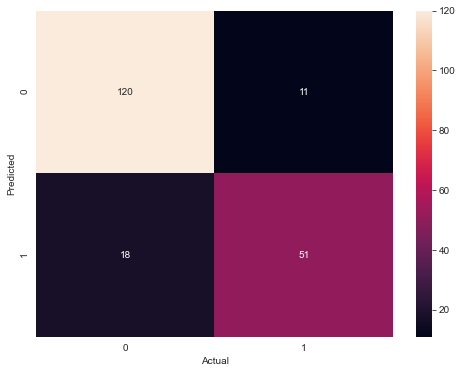

In [106]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_GB_n61,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

#### Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)

     0   1
0  120  11
1   18  51
tp_GB_n61 =  120
tn_GB_n61 =  51
fp_GB_n61 =  11
fn_GB_n61 =  18

recall_GB_n61 =  0.8695652173913043      precision_GB_n61 =  0.916030534351145

f1 score_GB_n61 =  0.8921933085501859

scores_GB_n61 = 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       131
           1       0.82      0.74      0.78        69

    accuracy                           0.85       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.85      0.85      0.85       200



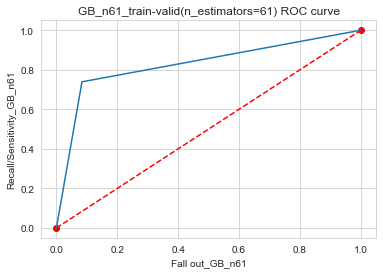

In [107]:
print(c_mat_df_GB_n61)
tp_GB_n61 = c_mat_df_GB_n61.loc[0,0]
print('tp_GB_n61 = ',tp_GB_n61)

tn_GB_n61 = c_mat_df_GB_n61.loc[1,1]
print('tn_GB_n61 = ',tn_GB_n61)

fp_GB_n61 = c_mat_df_GB_n61.loc[0,1]
print('fp_GB_n61 = ',fp_GB_n61)

fn_GB_n61 = c_mat_df_GB_n61.loc[1,0]
print('fn_GB_n61 = ',fn_GB_n61)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_GB_n61 = tp_GB_n61/(tp_GB_n61+fn_GB_n61)
precision_GB_n61 = tp_GB_n61/(tp_GB_n61+fp_GB_n61)
print('\nrecall_GB_n61 = ',recall_GB_n61,'     precision_GB_n61 = ',precision_GB_n61)

#F1 score = 2*(precision * recall)/precision + recall

f_score_GB_n61 = (2*recall_GB_n61*precision_GB_n61)/(recall_GB_n61+precision_GB_n61)
print('\nf1 score_GB_n61 = ',f_score_GB_n61)

# using the built in scikit-learn function to do this at one go!

scores_GB_n61 = classification_report(Y_valid,Y_pred_GB_n61)
print('\nscores_GB_n61 = \n',scores_GB_n61)

rec_GB_n61, fall_out_GB_n61, thresholds_GB_n61 = roc_curve(Y_valid,Y_pred_GB_n61)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_GB_n61,fall_out_GB_n61, label='my_GB_n61_df')
plt.xlabel('Fall out_GB_n61')
plt.ylabel('Recall/Sensitivity_GB_n61')
plt.title('GB_n61_train-valid(n_estimators=61) ROC curve')
plt.show()


### *Train_valid - Test evaluation*

#### Confusion matrix, Recall, and Precision

In [108]:
# accuracy score

accuracy_score(Y_t,Y_pred_GB_n61_t)

0.7703349282296651

In [109]:
'''Make a confusion matrix for the n_estimators=100 model based validation set predictions.
Make a pandas dataframe out of it so that we can use seaborn to 
plot it easily'''

c_mat_GB_n61_t = confusion_matrix(Y_t,Y_pred_GB_n61_t)
c_mat_df_GB_n61_t = pd.DataFrame(c_mat_GB_n61_t)
c_mat_df_GB_n61_t.head(2)

,0,1
0,108,10
1,38,53


Text(52.0, 0.5, 'Predicted')

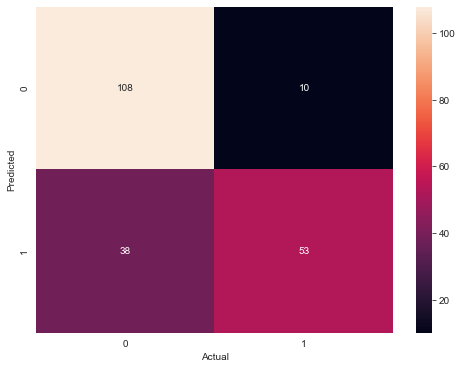

In [110]:
# Make a heatmap of the confusion matrix with seaborn

plt.figure(figsize = (8,6))
sns.heatmap(c_mat_df_GB_n61_t,annot = True,fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")

#### Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)

     0   1
0  108  10
1   38  53
tp_GB_n61_t =  108
tn_GB_n61_t =  53
fp_GB_n61_t =  10
fn_GB_n61_t =  38

recall_GB_n61_t =  0.7397260273972602      precision_GB_n61_t =  0.9152542372881356

f1 score_GB_n61_t =  0.818181818181818

scores_GB_n61_t = 
               precision    recall  f1-score   support

           0       0.74      0.92      0.82       118
           1       0.84      0.58      0.69        91

    accuracy                           0.77       209
   macro avg       0.79      0.75      0.75       209
weighted avg       0.78      0.77      0.76       209



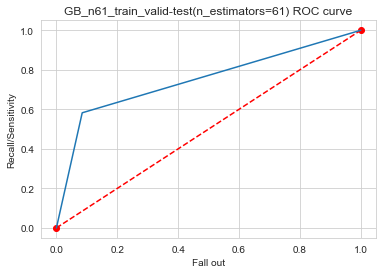

In [111]:
print(c_mat_df_GB_n61_t)
tp_GB_n61_t = c_mat_df_GB_n61_t.loc[0,0]
print('tp_GB_n61_t = ',tp_GB_n61_t)

tn_GB_n61_t = c_mat_df_GB_n61_t.loc[1,1]
print('tn_GB_n61_t = ',tn_GB_n61_t)

fp_GB_n61_t = c_mat_df_GB_n61_t.loc[0,1]
print('fp_GB_n61_t = ',fp_GB_n61_t)

fn_GB_n61_t = c_mat_df_GB_n61_t.loc[1,0]
print('fn_GB_n61_t = ',fn_GB_n61_t)

# Recall (Sensitivity) = tp/tp+fn, Precision = tp/tp+fp

recall_GB_n61_t = tp_GB_n61_t/(tp_GB_n61_t+fn_GB_n61_t)
precision_GB_n61_t = tp_GB_n61_t/(tp_GB_n61_t+fp_GB_n61_t)
print('\nrecall_GB_n61_t = ',recall_GB_n61_t,'     precision_GB_n61_t = ',precision_GB_n61_t)

#F1 score = 2*(precision * recall)/precision + recall

f_score_GB_n61_t = (2*recall_GB_n61_t*precision_GB_n61_t)/(recall_GB_n61_t+precision_GB_n61_t)
print('\nf1 score_GB_n61_t = ',f_score_GB_n61_t)

# using the built in scikit-learn function to do this at one go!

scores_GB_n61_t = classification_report(Y_t,Y_pred_GB_n61_t)
print('\nscores_GB_n61_t = \n',scores_GB_n61_t)

rec_GB_n61_t, fall_out_GB_n61_t, thresholds_GB_n61_t = roc_curve(Y_t,Y_pred_GB_n61_t)

plt.plot([0,1],[0,1],'ro--')
plt.plot(rec_GB_n61_t,fall_out_GB_n61_t, label='my_df_GB_n61_t')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('GB_n61_train_valid-test(n_estimators=61) ROC curve')
plt.show()

#### Summary:

Model: k-NN with n = 33 using imputation technique 1 (mode)</br>
Accuracy (train-valid): 0.595</br>
F1-Score (train-valid): 0.7096774193548389</br>
Accuracy (test): 0.5598086124401914</br>
F1-Score (test): 0.7177914110429447</br></br>

Model: k-NN with n = 33 using imputation technique 2 (KNNImputer) </br>
Accuracy (train-valid): 0.595</br>
F1-Score (train-valid): 0.7096774193548389</br>
Accuracy (test): 0.5598086124401914</br>
F1-Score (test): 0.7177914110429447</br></br>

Model: GradientBoosting with n_estimators = 100 (default) </br>
Accuracy (train-valid): 0.81</br>
F1-Score (train-valid): 0.8515625000000001</br>
Accuracy (test): 0.8133971291866029</br>
F1-Score (test): 0.8458498023715416</br></br>

Model: GradientBoosting with n_estimators = 61</br>
Accuracy (train-valid): 0.855</br>
F1-Score (train-valid): 0.8921933085501859</br>
Accuracy (test): 0.7703349282296651</br>
F1-Score (test): 0.818181818181818</br>


In [112]:
# CONCLUSION:
# 1. Ensemble techniques can greatly improve prediction performance for a dataset
# 2. Increasing number of decision trees may improve performance in GradientBoosting, upto certain number of trees. But, the model is succeptible to being overfit.